In [9]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
import pyBigWig
import gget
import pysam

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())

In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_rnaseq/"

for f in os.listdir(dirpath):
    print(f)

4DNFI12AUKQS.bw
4DNFIUW8CG2I.bw
4DNFI8CSCJWM.tsv
4DNFI7FO9H19.bam
4DNESZ741PJM_processed_files_2022-05-30-14h-43m.tsv
4DNFI3YYNDKI.tsv
4DNFIPYGE7JR.tsv
4DNFIXOTRTRM.bw
4DNFIYTCHMIZ.tsv
4DNFIFVPB94O.bw
4DNFISUXPL3L.bam


In [4]:
filepath = f"{dirpath}4DNESZ741PJM_processed_files_2022-05-30-14h-43m.tsv"
summary = pd.read_csv(filepath, sep='\t', comment='#')

summary['Filename'] = summary['File Download URL'].apply(lambda x: x.split("/")[-1])
cols = ['Filename', 'Experiment Accession', 'File Accession', 'Size (MB)', 'File Type', 'File Format',]
summary[cols]

,Filename,Experiment Accession,File Accession,Size (MB),File Type,File Format
0,4DNFI7FO9H19.bam,4DNEXCHOKPKJ,4DNFI7FO9H19,1503.75,read positions,bam
1,4DNFI8CSCJWM.tsv,4DNEXCHOKPKJ,4DNFI8CSCJWM,23.19,isoform expression,tsv
2,4DNFIUW8CG2I.bw,4DNEXCHOKPKJ,4DNFIUW8CG2I,42.86,read counts (plus),bw
3,4DNFIXOTRTRM.bw,4DNEXCHOKPKJ,4DNFIXOTRTRM,42.06,read counts (minus),bw
4,4DNFIYTCHMIZ.tsv,4DNEXCHOKPKJ,4DNFIYTCHMIZ,11.23,gene expression,tsv
5,4DNFI12AUKQS.bw,4DNEXGMSIOHL,4DNFI12AUKQS,31.51,read counts (plus),bw
6,4DNFI3YYNDKI.tsv,4DNEXGMSIOHL,4DNFI3YYNDKI,11.23,gene expression,tsv
7,4DNFIFVPB94O.bw,4DNEXGMSIOHL,4DNFIFVPB94O,30.93,read counts (minus),bw
8,4DNFIPYGE7JR.tsv,4DNEXGMSIOHL,4DNFIPYGE7JR,23.18,isoform expression,tsv
9,4DNFISUXPL3L.bam,4DNEXGMSIOHL,4DNFISUXPL3L,1063.16,read positions,bam


In [5]:
assembly

,Chromosome,Total length,GenBank accession,RefSeq accession,chromEnd,chromStart
0,1,195154279,CM000994.3,NC_000067.7,195154279,0
1,2,181755017,CM000995.3,NC_000068.8,376909296,195154279
2,3,159745316,CM000996.3,NC_000069.7,536654612,376909296
3,4,156860686,CM000997.3,NC_000070.7,693515298,536654612
4,5,151758149,CM000998.3,NC_000071.7,845273447,693515298
5,6,149588044,CM000999.3,NC_000072.7,994861491,845273447
6,7,144995196,CM001000.3,NC_000073.7,1139856687,994861491
7,8,130127694,CM001001.3,NC_000074.7,1269984381,1139856687
8,9,124359700,CM001002.3,NC_000075.7,1394344081,1269984381
9,10,130530862,CM001003.3,NC_000076.7,1524874943,1394344081


In [6]:
file = '4DNFIUW8CG2I.bw'

fullpath = f"{dirpath}{file}"
bw = pyBigWig.open(fullpath)

chrom = 2
resolution = 1000000 # 1mb scale
chrmStr = f"chr{2}"
chromStart = assembly.loc[assembly['Chromosome'] == str(chrom)]['chromStart'].values[0]
chromEnd = assembly.loc[assembly['Chromosome'] == str(chrom)]['chromEnd'].values[0]
chromLen = int(chromEnd - chromStart)


newRows = []

cnt = 0
for i, b in enumerate(range(0, chromLen, resolution)):
    binStart = b
    binEnd = b + resolution - 1

    t = bw.stats('chr2', binStart, binEnd)[0]
    
    row = {
        'bin' : i,
        'binStart' : binStart,
        'binEnd' : binEnd,
        'meanExp' : t
    }
    
    newRows.append(row)
    
    
df = pd.DataFrame(newRows)
print(f"{df.shape=}")
df.head()

df.shape=(182, 4)


,bin,binStart,binEnd,meanExp
0,0,0,999999,NaN
1,1,1000000,1999999,NaN
2,2,2000000,2999999,NaN
3,3,3000000,3999999,0.194051
4,4,4000000,4999999,0.127028


<BarContainer object of 182 artists>

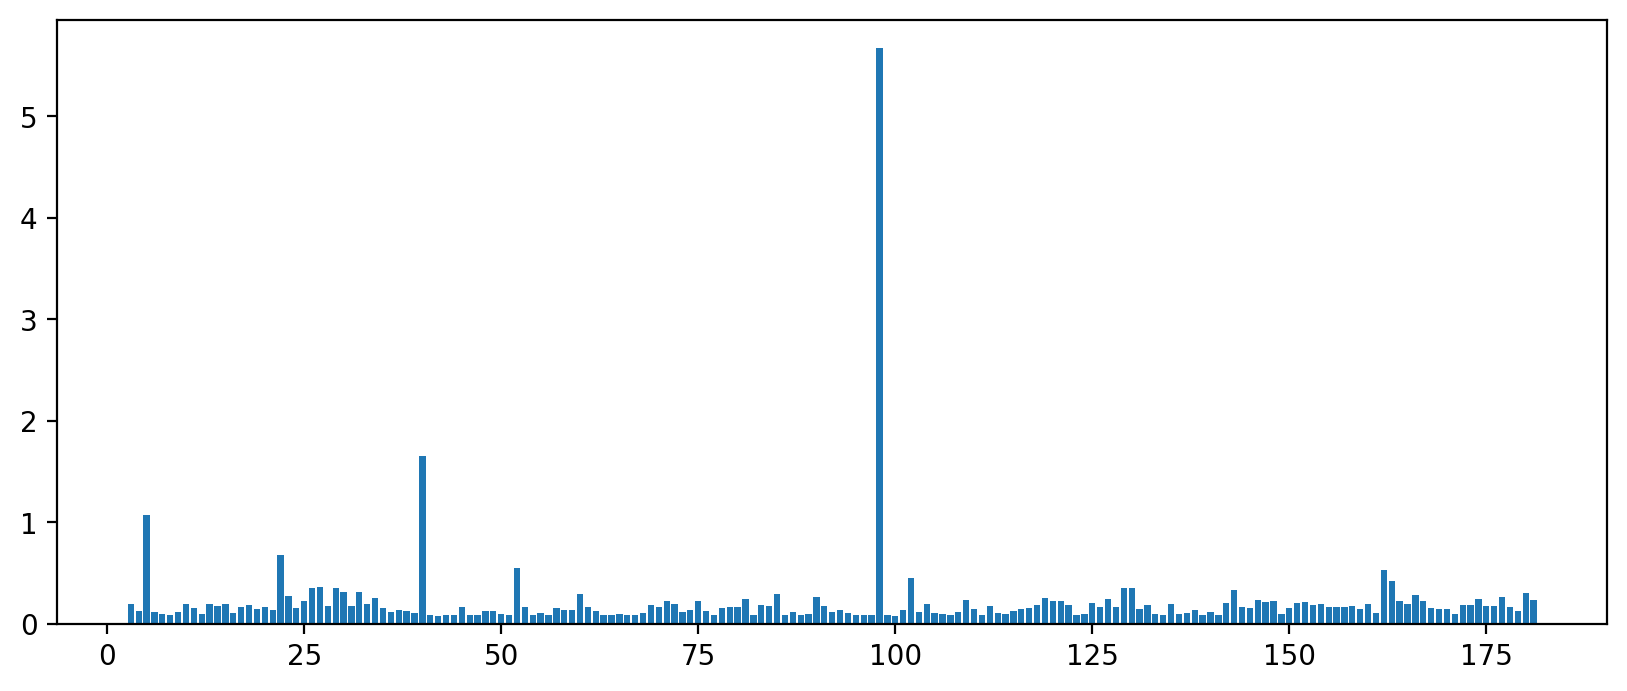

In [8]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 4

plt.bar(range(len(df)), df['meanExp'])